### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
import skimage.io as io

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
%matplotlib inline

In [5]:
from preprocess.common import load_nii

In [6]:
from torch.utils.data import DataLoader
from torchcontrib.optim import SWA

# ---- My utils ----
from utils.data_augmentation import data_augmentation_selector
from utils.dataload import *
from utils.training import *

In [7]:
train_aug, train_aug_img, val_aug = data_augmentation_selector("none", 224, 224)

Using None Data Augmentation


In [8]:
data_partition = "train"
general_aug, img_aug = train_aug, train_aug_img
normalization = "standardize"
fold_system = "patient"
label_type = "mask"


train_dataset = MMsDataset(
    mode=data_partition, transform=general_aug, img_transform=img_aug,
    folding_system=fold_system, normalization=normalization, label_type=label_type
)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)

In [13]:
image, mask = next(iter(train_loader))
image = image.squeeze()
mask = mask.squeeze()

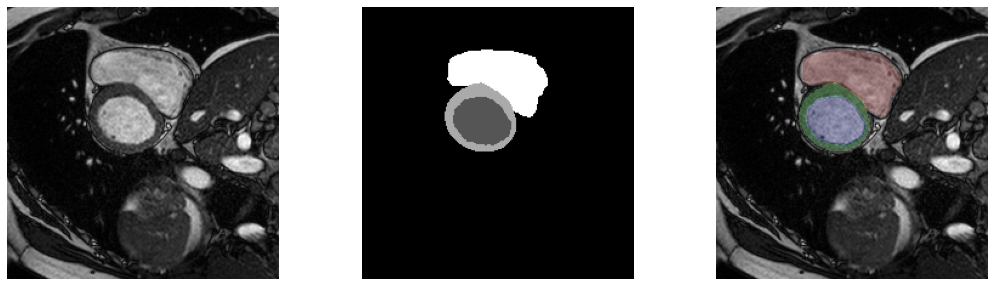

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')

ax1.imshow(image, cmap="gray")
ax2.imshow(mask, cmap="gray")

masked = np.ma.masked_where(mask == 0, mask)
ax3.imshow(image, cmap="gray")
ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)

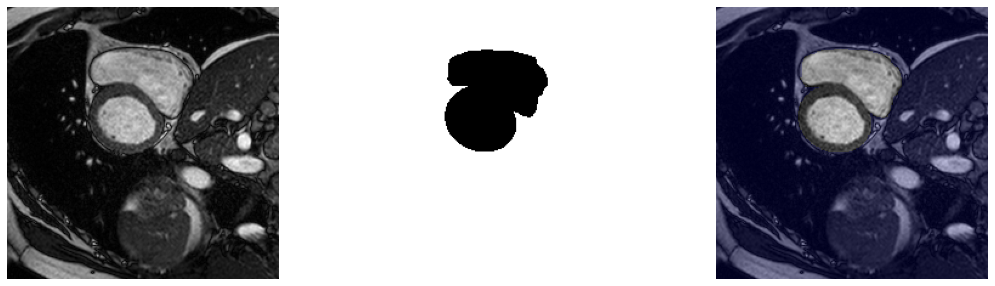

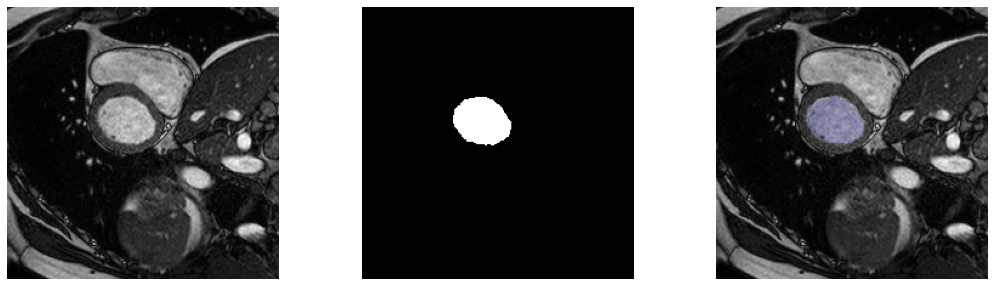

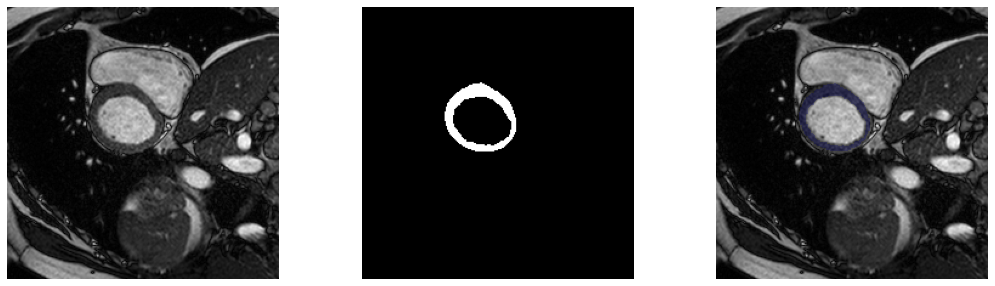

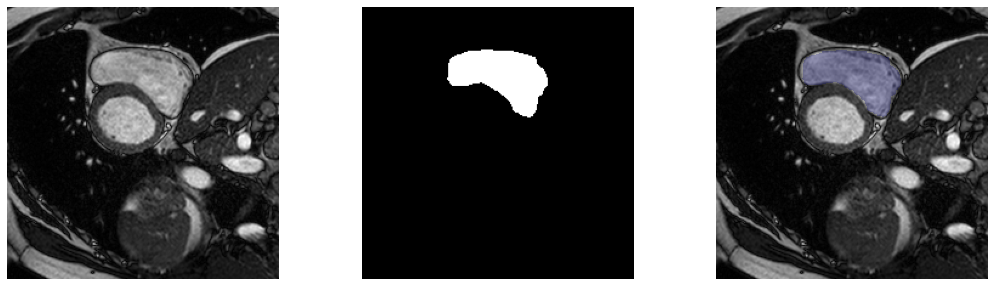

In [15]:
for current_class in mask.unique():
    tmp_mask = 1 - (mask != current_class) * 1.0
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.axis('off'); ax2.axis('off'); ax3.axis('off')

    ax1.imshow(image, cmap="gray")
    ax2.imshow(tmp_mask, cmap="gray")

    masked = np.ma.masked_where(tmp_mask == 0, tmp_mask)
    ax3.imshow(image, cmap="gray")
    ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)

### Detecting borders

In [16]:
import torch.nn.functional as F

In [17]:
lv_class = 1
myo_class = 2
rv_class = 3

In [18]:
lv_mask = 1 - (mask != lv_class) * 1.0
myo_mask = 1 - (mask != myo_class) * 1.0
rv_mask = 1 - (mask != rv_class) * 1.0

#### Rv problem

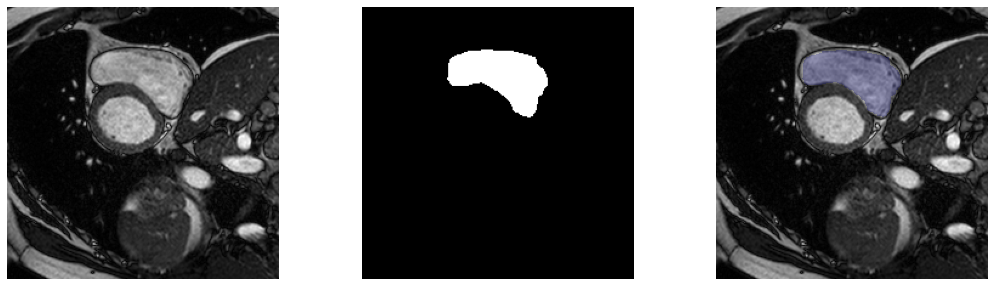

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')

ax1.imshow(image, cmap="gray")
ax2.imshow(rv_mask, cmap="gray")

masked = np.ma.masked_where(rv_mask == 0, rv_mask)
ax3.imshow(image, cmap="gray")
ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)

----------------

In [55]:
kernel_size = 3
mask_pool = F.avg_pool2d(rv_mask.unsqueeze(0), kernel_size=kernel_size, padding=kernel_size // 2, stride=1)
ind = mask_pool.ge(0.01) * mask_pool.le(0.99)
ind = ind.float()

Text(0.5, 1.0, 'Index Matrix')

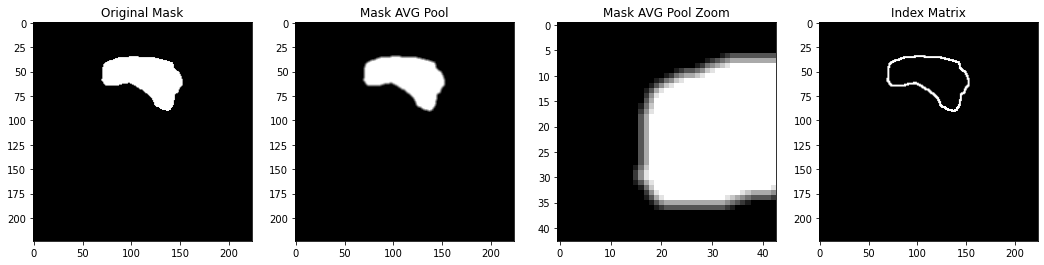

In [56]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 5))
#ax1.axis('off'); ax2.axis('off')

ax1.imshow(rv_mask, cmap="gray")
ax1.set_title("Original Mask")

ax2.imshow(mask_pool.squeeze(), cmap="gray")
ax2.set_title("Mask AVG Pool")

ax3.imshow(mask_pool[0, 29:72, 54: 97], cmap="gray")
ax3.set_title("Mask AVG Pool Zoom")

ax4.imshow(ind.squeeze(), cmap="gray")
ax4.set_title("Index Matrix")

In [57]:
mask_pool.unique()

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

Como podemos ver, la aplicacion del average poooling hace que los valores de los bordes de la mascara estén comprendidos entre 0 y 1 mientras que los del exterior que no tocan son 0 y los del interior 1. Por tanto, para tomar el borde debemos coger aquellos valores del average pool comprendidos entre mayor a 0 (sin cogerlo ya que es background) *mask_pool.ge(0.01)* (ge==greater equal) y menor a 1 (sin cogerlo para evitar los de relleno de la mascara, de su interior) *mask_pool.le(0.99)* (le==lower equal)

In [58]:
weights = torch.ones(mask_pool.size()).to(device=mask_pool.device)
weights.unique()

tensor([1.])

In [59]:
w0 = weights.sum()
weights = weights + ind * 2
w1 = weights.sum()
weights = weights / w1 * w0
weights.unique()

tensor([0.9779, 2.9336])

In [64]:
weights

tensor([[[0.9779, 0.9779, 0.9779,  ..., 0.9779, 0.9779, 0.9779],
         [0.9779, 0.9779, 0.9779,  ..., 0.9779, 0.9779, 0.9779],
         [0.9779, 0.9779, 0.9779,  ..., 0.9779, 0.9779, 0.9779],
         ...,
         [0.9779, 0.9779, 0.9779,  ..., 0.9779, 0.9779, 0.9779],
         [0.9779, 0.9779, 0.9779,  ..., 0.9779, 0.9779, 0.9779],
         [0.9779, 0.9779, 0.9779,  ..., 0.9779, 0.9779, 0.9779]]])

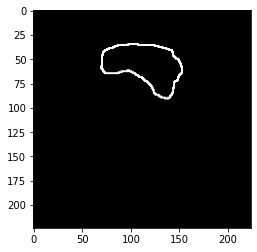

In [63]:
plt.imshow(weights.squeeze(), cmap="gray")